In [254]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d.axes3d import get_test_data # for 3d plotting
#import utils as ut # file containing a function to construct minibatches 

%matplotlib inline

#np.random.seed(1)

In [255]:
def relu( x ):
    x = np.maximum(5,x)
    return np.minimum( -5, x )
#    return np.maximum(0,x)


In [256]:
def drelu( x ):
    return np.where( (x > -5) & (x < 5) , 1, 0 )
#    return np.where(x>0, 1, 0)

In [257]:
def trunC( x ):
    x = np.maximum(-1000,x)
    return np.minimum(1000, x)

In [258]:
def dtrunC(x):
    return np.where( (x > -1000) & (x < 1000) , 1, 0 )

In [259]:
def initialize_parameters( n_y, n_n, num_layers):
    """
    Arguments:
    n_z -- the number of features in the input data
    n_y -- the number of features of the output data
    n_n -- number of neurons in each layer
    L -- the number of layers
    
    Returns:
    parameters -- python dictionary containing parameters "C1", "W1", "B1" "b1", ..., "CL", "WL", "BL", "bL":
                    C -- weight matrix of shape (n_n, n_y, n_y)
                    W -- weight matrix of shape (n_n, n_y, n_y)
                    b -- bias vector of shape (n_n, n_y, 1)
    """
    
    norm = 10
    
    C = np.random.randn(n_n, n_y, 1, num_layers-1) * norm
    W = np.random.randn(n_n, n_y, n_y, num_layers-1)* norm
    b = np.random.randn(n_n, n_y, 1, num_layers-1)* norm
        
    return (C, W, b)

In [260]:
def forward_propagation(z, C, W, b, num_layers, dt):
    """
    Implement forward propagation for L layers (see formula for dX)
    
    Arguments:
    z -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters()
    L -- number of layers
    dt -- parameter of gradient update rule
    
    Returns:
    caches -- list of caches containing:
                the output of the linear unit and of the nonlinear activation of every layer
                (there are L-1 of them, indexed from 1 to L-1)
    """
    
    n_y = b.shape[ 1 ]
    n_n = b.shape[ 0 ]
    m = z.shape[1]
 
    XA = np.zeros((n_y, m, num_layers))
    XA[:,:, 0] = z
    
    
    # Implement dX formula. Add "cache" to the "caches" list.
    for l in range( num_layers - 1):
        
        LX = np.matmul( W[:,:,:, l], XA[:,:,l] ) + b[:,:,:,l] #  dim: nn,ny,m

        dX = np.mean( trunC(C[:,:,:,l]) * relu( LX ) , axis = 0 ) * dt
        
        
        XA[:,:,l+1] = dX + XA[:,:,l]
        
            
    return XA

In [261]:
def backward_propagation(XL, Y, XA, C, W, b, num_layers, dt, ds, lam, eps):
    """
    Implement the backward propagation (see formulas for dtheta and dp)
    
    Arguments:
    XL -- output of the forward propagation
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches 
                
    
    Returns:
    parameters -- a dictionary of updated parameters
    
    """
    m = Y.shape[ 1 ]
    n_y = Y.shape[ 0 ]
    n_n = C.shape[ 0 ]
    
    # Initializing the backpropagation
    P =  XA[:,:,num_layers-1 ] - Y 
    
    # Creating the same delta W for all layers (i.e. all t)
    C_noise = np.random.randn( n_n, n_y, 1 )
    W_noise = np.random.randn( n_n, n_y, n_y )
    b_noise = np.random.randn( n_n, n_y, 1 )
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(num_layers-1)):
        X = XA[:,:, l ]                  #dimension: dy, m
        
        Cl = C[:,:,:, l]
        Wl = W[:,:,:, l]
        bl = b[:,:,:,l]

        LX = np.matmul( Wl, X ) + bl       #dimension: n_n, d_y, m
        AX = relu( LX )  
        dAX = drelu( LX )
        
        # In the update rule for theta should one use P or P_prev?

        BX = trunC(Cl) * dAX                   #dimension: n_n, d_y, m

        
        dC = (- lam * Cl - np.mean(AX * P, axis =2, keepdims = True)* dtrunC(Cl)) * ds + eps * np.sqrt(ds) * C_noise
        C[:,:,:, l] = Cl + dC
        
                                   
        dW = (- lam * Wl - np.matmul( BX * P , X.T ) / m) * ds + eps * np.sqrt(ds) * W_noise
                                   
        W[:,:,:, l] = Wl + dW
           
    
        db = (- lam * bl - np.mean( BX * P, axis =2 , keepdims = True) ) * ds + eps * np.sqrt(ds) * b_noise
        b[:,:,:, l] = bl + db
        
        temp = np.transpose(BX.reshape(1, n_n, n_y, m), axes = (0,3,1,2))
        WW   = np.transpose(Wl.reshape(1, n_n, n_y, n_y), axes =(3,0,1,2))
        
        dP =   np.sum(np.mean(temp * WW, axis = 2) * P.T, axis = 2) * dt
        P = P + dP                      #dimension: d_y, m
                                   
    return (C, W, b)

In [262]:
def deep_nn_model(z, Y, num_layers, n_n, dt = 0.01, ds = 0.01, lam = 0.1, eps = 0.1, 
                  num_epochs = 1000, print_cost=True ):
    """
    Implements a L-layer neural network.
    
    Arguments:
    z -- data, numpy array of shape (number of features, number of examples)
    Y -- true "label" vector, of shape (n_y, number of examples)
    num_layers -- number of layers
    n_n -- number of neurons in each layer
    minibatch_size -- size of minibatch
    dt -- parameter of the gradient update rule
    lam -- parameter of the gradient update rule
    eps -- parameter of the gradient update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    #np.random.seed(1)
    costs = []   # keep track of cost
    Clvars =[]
    
    n_y = Y.shape[ 0 ]
    
    #seed = 1 # for constructing minibatches
    
    # Parameters initialization.
    (C, W, b) = initialize_parameters( n_y, n_n, num_layers )
    
    it_num = 0
    
    # Loop (optimization)
    for i in range(num_epochs):
                
        # Forward propagation.
        XA = forward_propagation( z, C, W, b, num_layers, dt )
            
        XL = XA[:,:,num_layers-1]
        
        # Compute cost.
        cost = np.mean( np.linalg.norm( Y - XL , ord = 2, axis = 0 ) ) / 2
    
        cost = np.squeeze(cost)  
                
        # Backward propagation.
        (C, W, b) = backward_propagation( XL, Y, 
                                                  XA, C, W, b, num_layers, dt, ds, lam, eps )
            
        costs.append(cost)
         
        
      
        Clvars.append(np.squeeze(np.var(C[:,:,:,0], axis = 0)))
            
            
        it_num = it_num + 1
            
        # Print the cost every 100 training example
        if print_cost and it_num % 100 == 0:
            print ("Cost after iteration %i: %f" %(it_num, cost))
                



        
    
            
    # plot the cost
    fig = plt.figure( figsize = (8,3) )
    ax0 = fig.add_subplot( 1, 2, 1 )
    ax0.plot(  costs  ) 
    ax0.set_ylabel('cost')
    ax0.set_xlabel('iterations')
    ax0.set_title("dt =" + str(dt))
    
    fig = plt.figure( figsize = (8,3) )
    plt.plot(Clvars)

    
    return (C, W, b)

Cost after iteration 100: 0.893168
Cost after iteration 200: 0.897841
Cost after iteration 300: 0.901511
Cost after iteration 400: 0.896260
Cost after iteration 500: 0.892735
Cost after iteration 600: 0.914060
Cost after iteration 700: 0.891450
Cost after iteration 800: 0.906412
Cost after iteration 900: 0.895133
Cost after iteration 1000: 0.892779


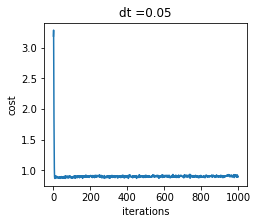

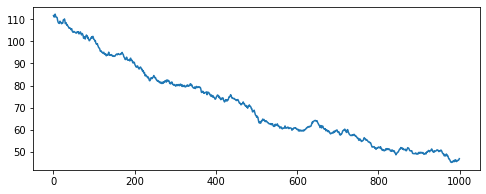

In [263]:
#regression for a simple function: training errors

#Z = np.random.exponential( 1, ( 1, 1000 ) )
z =  np.linspace( 0 , 5.0, 12 )+np.random.randn(1,12)*0.2                 
Y =  np.cos(z-2)



num_layers =21
dt =0.05
n_n = 5

(C, W, b) = deep_nn_model( z, Y, num_layers , n_n , dt , ds = 0.01, lam = 0.05, eps = 0.5, 
                  num_epochs = 1000 )


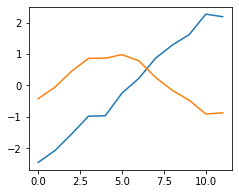

In [264]:
F = forward_propagation(z, C, W, b,  num_layers = 21 , dt= 0.05)

FL = F[:,:,-1]


fig = plt.figure( figsize = (8,3) )
ax0 = fig.add_subplot( 1, 2, 1 )
ax0.plot(  np.squeeze(FL)  ) 
ax0.plot(np.squeeze(Y))

In [265]:
# Test on trigonometric functions
z1 = np.linspace( -1.0 , 1.0, 100 )
z2 = np.linspace( -1.0 , 1.0, 100 )

Z1, Z2 = np.meshgrid( z1, z2 )
Y = Z1*Z1 + Z2*Z2
Y = Y.reshape( 1, 10000 )

z = np.array( [ np.squeeze( Z1.reshape( 1, 10000 ) ), np.squeeze( Z2.reshape( 1, 10000 ) ) ] )
print( z.shape )

(2, 10000)


In [266]:
num_layers = 10

In [267]:
parameters = deep_nn_model( z, Y, num_layers, n_n = 10, minibatch_size = 32, num_epochs = 100 )

TypeError: deep_nn_model() got an unexpected keyword argument 'minibatch_size'

In [ ]:
# Test on MNIST
from mlxtend.data import loadlocal_mnist

z, y = loadlocal_mnist(
        images_path='MNIST/train-images-idx3-ubyte', 
        labels_path='MNIST/train-labels-idx1-ubyte')

In [ ]:
print( z.shape )
print( y.shape )

In [ ]:
z_train = z * 1.0 / 255.0
z_train = z_train.T

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder( sparse = False )
y_train = y.reshape( 60000, 1 )
y_train = enc.fit_transform( y_train )
y_train = y_train.T

In [ ]:
parameters = deep_nn_model( z_train, y_train, num_layers = 10, n_n = 5, 
                           minibatch_size = 512, dt = 0.01, num_epochs = ( 1400 // (60000 // 512) + 1 ) )

In [ ]:
parameters = deep_nn_model( z_train, y_train, num_layers = 10, n_n = 5, 
                           minibatch_size = 512, dt = 0.5, lam = 0.0001, eps = 0.01, num_epochs = ( 
                               1400 // (60000 // 512) + 1 ) )

In [ ]:
parameters = deep_nn_model( z_train, y_train, num_layers = 10, n_n = 5, 
                           minibatch_size = 512, dt = 1, lam = 0.0001, eps = 0.01, num_epochs = ( 
                               1400 // (60000 // 512) + 1 ) )

In [ ]:
parameters = deep_nn_model( z_train, y_train, num_layers = 2, n_n = 5, 
                           minibatch_size = 512, dt = 1, lam = 0.0001, eps = 0.01, num_epochs = ( 
                               1400 // (60000 // 512) + 1 ) )

In [ ]:
parameters = deep_nn_model( z_train, y_train, num_layers = 150, n_n = 5, 
                           minibatch_size = 512, dt = 0.01, lam = 0.0001, eps = 0.01, num_epochs = ( 
                               1400 // (60000 // 512) + 1 ) )

In [ ]:
parameters = deep_nn_model( z_train, y_train, num_layers = 10, n_n = 5, 
                           minibatch_size = 512, dt = 0.01, lam = 0.0001, eps = 0.01, num_epochs = ( 
                               1400 // (60000 // 512) + 1 ) )

In [ ]:
parameters = deep_nn_model( z_train, y_train, num_layers = 30, n_n = 5, 
                           minibatch_size = 512, dt = 1, lam = 0.0001, eps = 0.01, num_epochs = ( 
                               1400 // (60000 // 512) + 1 ) )

In [ ]:
parameters = deep_nn_model( z_train, y_train, num_layers = 30, n_n = 5, 
                           minibatch_size = 512, dt = 0.1, lam = 0.0001, eps = 0.01, num_epochs = ( 
                               1400 // (60000 // 512) + 1 ) )